In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import os
import sys

from utilities2015 import *

import time

from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import average, fcluster, single, complete

from joblib import Parallel, delayed

from skimage.color import gray2rgb
from skimage.measure import find_contours
from skimage.util import img_as_float

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('/home/yuncong/project/opencv-2.4.9/release/lib/python2.7/site-packages')
import cv2

from networkx import from_dict_of_lists, Graph, adjacency_matrix, dfs_postorder_nodes
from networkx.algorithms import node_connected_component

stack_name = 'MD593'

In [4]:
def compute_cluster_score(cluster, texton_hists, neighbors):
    
    cluster_list = list(cluster)
    cluster_avg = texton_hists[cluster_list].mean(axis=0)
    
    surrounds = set([i for i in set.union(*[neighbors[c] for c in cluster]) if i not in cluster and i != -1])
    if len(surrounds) == 0: # single sp on background
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    
    surrounds_list = list(surrounds)
    surround_dist = np.squeeze(cdist([cluster_avg], texton_hists[surrounds_list], chi2)).min()

    surds, _ = find_boundary_sps([cluster], neighbors=neighbors, neighbor_graph=neighbor_graph)
    
    compactness = len(surds[0])**2/float(len(cluster))
    compactness = .001 * np.maximum(compactness-40,0)**2
    
    size_prior = .1 * (1-np.exp(-.8*len(cluster)))
    
    score = surround_dist - compactness + size_prior
    
    interior_dist = np.nan
    interior_pval = np.nan
    surround_pval = np.nan
    
    return score, surround_dist, interior_dist, compactness, surround_pval, interior_pval, size_prior

In [5]:
def grow_cluster3(seed, texton_hists, neighbors=None, output=False, all_history=False):
    
    if neighbors is None:
        neighbors = neighbors_global
    
    visited = set([])
    curr_cluster = set([])
        
    candidate_scores = [0]
    candidate_sps = [seed]

    score_tuples = []
    added_sps = []
    
    iter_ind = 0
        
    while len(candidate_sps) > 0:

        best_ind = np.argmax(candidate_scores)
        
        heuristic = candidate_scores[best_ind]
        sp = candidate_sps[best_ind]
        
        del candidate_scores[best_ind]
        del candidate_sps[best_ind]
        
        if sp in curr_cluster:
            continue
                
        iter_ind += 1
        curr_cluster.add(sp)
        added_sps.append(sp)
        
        tt = compute_cluster_score(curr_cluster, texton_hists=texton_hists, neighbors=neighbors)
        tot, exterior, interior, compactness, surround_pval, interior_pval, size_prior = tt
        if np.isnan(tot):
            return [seed], -np.inf
        score_tuples.append(np.r_[heuristic, tt])
        
        if output:
            print 'iter', iter_ind, 'add', sp

        visited.add(sp)
        
        candidate_sps = (set(candidate_sps) | (neighbors[sp] - set([-1])) | (visited - curr_cluster)) - curr_cluster
        candidate_sps = list(candidate_sps)
        
#         f_avg = texton_freqs[list(curr_cluster)].sum(axis=0)
#         candidate_scores = [chi2pval(f_avg, texton_freqs[i])[0] for i in candidate_sps]

        h_avg = texton_hists[list(curr_cluster)].mean(axis=0)
        candidate_scores = [-chi2(h_avg, texton_hists[i]) for i in candidate_sps]

#         candidate_scores = [compute_cluster_score(curr_cluster | set([s])) for s in candidate_sps]
                
        if len(visited) > int(n_superpixels * 0.02):
            break

    score_tuples = np.array(score_tuples)
    
    min_size = 2
    scores = score_tuples[:,1]
    cutoff = np.argmax(scores[min_size:]) + min_size
    
    if output:
        print 'cutoff', cutoff

    final_cluster = added_sps[:cutoff]
    final_score = scores[cutoff]
    
    if all_history:
        return list(final_cluster), final_score, added_sps, score_tuples
    else:
        return list(final_cluster), final_score

In [6]:
def compute_overlap(c1, c2):
    return float(len(c1 & c2)) / min(len(c1),len(c2))

def compute_overlap2(c1, c2):
    return float(len(c1 & c2)) / len(c1 | c2)    

def compute_overlap_partial(indices, sets, metric=1):
    n_sets = len(sets)
    
    overlap_matrix = np.zeros((len(indices), n_sets))
        
    for ii, i in enumerate(indices):
        for j in range(n_sets):
            c1 = set(sets[i])
            c2 = set(sets[j])
            if len(c1) == 0 or len(c2) == 0:
                overlap_matrix[ii, j] = 0
            else:
                if metric == 1:
                    overlap_matrix[ii, j] = compute_overlap(c1, c2)
                elif metric == 2:
                    overlap_matrix[ii, j] = compute_overlap2(c1, c2)
            
    return overlap_matrix

def set_pairwise_distances(sets, metric):

    partial_overlap_mat = Parallel(n_jobs=16, max_nbytes=1e6)(delayed(compute_overlap_partial)(s, sets, metric=metric) 
                                        for s in np.array_split(range(len(sets)), 16))
    overlap_matrix = np.vstack(partial_overlap_mat)
    distance_matrix = 1 - overlap_matrix
    
    np.fill_diagonal(distance_matrix, 0)
    
    return distance_matrix

def group_clusters(clusters=None, dist_thresh = 0.1, distance_matrix=None, metric=1):

    if distance_matrix is None:
        assert clusters is not None
        distance_matrix = set_pairwise_distances(clusters, metric)
        
    lk = average(squareform(distance_matrix))
#     lk = single(squareform(distance_matrix))

    # T = fcluster(lk, 1.15, criterion='inconsistent')
    T = fcluster(lk, dist_thresh, criterion='distance')
    # Note that T starts from 1 not 0 !!!
    
    n_groups = len(set(T))    
    groups = [None] * n_groups

    for group_id in range(n_groups):
        groups[group_id] = np.where(T == group_id+1)[0]
        
    return [g for g in groups if len(g) > 0]

In [7]:
def spSet_to_edgeSet(cluster, n_superpixels, neighbors=None, fill_holes=False):

    
    if neighbors is None:
        neighbors = neighbors_global

    
    cluster = set(cluster)
    
    surrounds = set([i for i in set.union(*[neighbors[c] for c in cluster]) if i not in cluster and i != -1])
    surrounds = set([i for i in surrounds if any([n not in cluster for n in neighbors[i]])])

    if fill_holes:    
        outside = set(range(n_superpixels)) - cluster - surrounds
        hole_candidates = set(range(n_superpixels)) - cluster
    
        goon = True
        while goon:
            goon = False
            for hc in hole_candidates - outside:
                if any([s in outside for s in neighbors[hc]]):
        #             print hc
                    outside.add(hc)
                    goon = True

        holes = set(range(n_superpixels)) - outside - cluster
    #     print holes

        cluster = set(cluster) | holes

    surrounds = set([i for i in set.union(*[neighbors[c] for c in cluster]) if i not in cluster and i != -1])
    surrounds = set([i for i in surrounds if any([n not in cluster for n in neighbors[i]])])

    # only happen in island node
    if len(surrounds) == 0:
        return []
    else:
        frontiers = set.union(*[neighbors[c] for c in surrounds]) & set(cluster)    

    region_edges = []
    for s in surrounds:
        for f in neighbors[s] & set(frontiers):
            region_edges.append((s, f))

    for i in cluster:
        if -1 in neighbors[i]:
            region_edges.append((-1, i))

    return sorted(region_edges)

In [23]:
def find_boundary_sps(clusters, neighbors, neighbor_graph):
    '''
    Identify superpixels that are at the boundary of regions: surround set and frontier set
    
    Parameters
    ----------
    clusters : list of integer lists
    neighbors : neighbor_list
    neighbor_graph : 
    '''
        
    n_superpixels = len(clusters)
    
    surrounds_sps = []
    frontiers_sps = []
    
    for cluster_ind, cluster in enumerate(clusters):
        
        surrounds = set([i for i in set.union(*[neighbors[c] for c in cluster]) if i not in cluster and i != -1])
#         surrounds = set([i for i in surrounds if any([(n not in cluster) and (n not in surrounds) for n in neighbors[i]])])
        surrounds = set([i for i in surrounds if any([n not in cluster for n in neighbors[i]])])

        if len(surrounds) == 0:
            surrounds_sps.append([])
            frontiers_sps.append([])

        else:
            frontiers = set.union(*[neighbors[c] for c in surrounds]) & set(cluster)

            surrounds_subgraph = neighbor_graph.subgraph(surrounds)
            surrounds_traversal = list(dfs_postorder_nodes(surrounds_subgraph))

            frontiers_subgraph = neighbor_graph.subgraph(frontiers)
            frontiers_traversal = list(dfs_postorder_nodes(frontiers_subgraph))

            surrounds_sps.append(surrounds_traversal)
            frontiers_sps.append(frontiers_traversal)
        
    return surrounds_sps, frontiers_sps

In [24]:
section_id = 100

os.environ['GORDON_DATA_DIR'] = '/oasis/projects/nsf/csd395/yuncong/CSHL_data_processed'
os.environ['GORDON_REPO_DIR'] = '/oasis/projects/nsf/csd395/yuncong/Brain'
os.environ['GORDON_RESULT_DIR'] = '/oasis/projects/nsf/csd395/yuncong/CSHL_data_results'

dm = DataManager(data_dir=os.environ['GORDON_DATA_DIR'], repo_dir=os.environ['GORDON_REPO_DIR'], 
                 result_dir=os.environ['GORDON_RESULT_DIR'], labeling_dir=os.environ['GORDON_LABELING_DIR'],
                 stack=stack_name, section=section_id)

# dm._load_image()

In [25]:
texton_hists = dm.load_pipeline_result('texHist', 'npy')
segmentation = dm.load_pipeline_result('segmentation', 'npy')
n_superpixels = segmentation.max() + 1
textonmap = dm.load_pipeline_result('texMap', 'npy')
n_texton = textonmap.max() + 1
neighbors = dm.load_pipeline_result('neighbors', 'pkl')
neighbors_global = neighbors

segmentation_vis = dm.load_pipeline_result('segmentationWithoutText', 'jpg')

In [26]:
neighbors_dict = dict(zip(np.arange(n_superpixels), [list(i) for i in neighbors]))
neighbor_graph = from_dict_of_lists(neighbors_dict)

In [54]:
ret = grow_cluster3(3783, texton_hists=texton_hists, all_history=True)

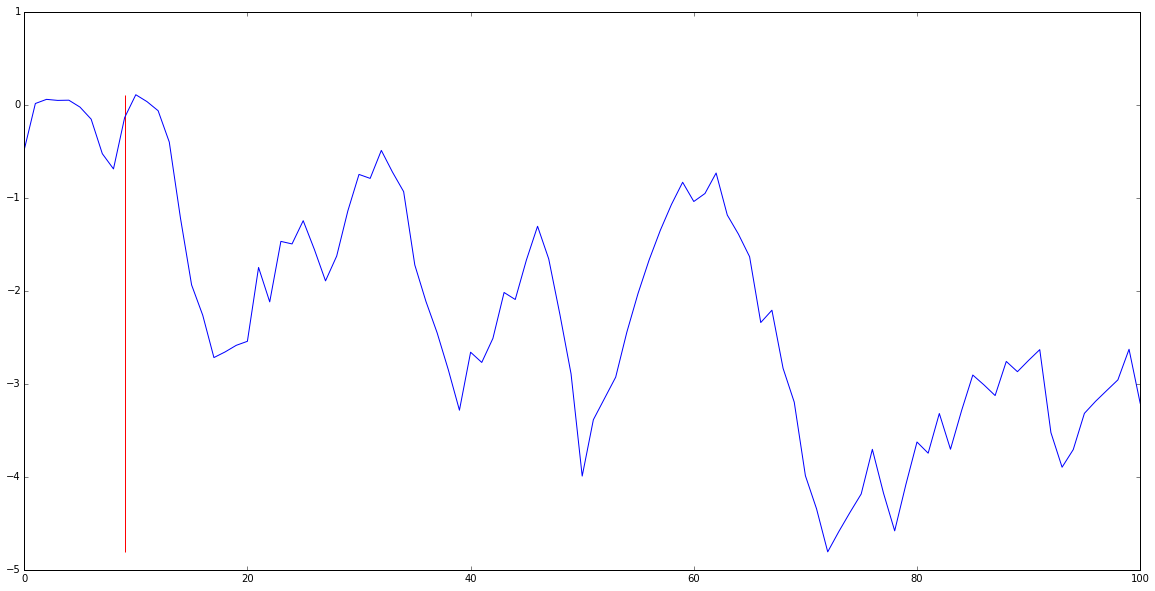

In [56]:
plt.figure(figsize=(20,10));
plt.plot(ret[3][:,1]);
# plt.xticks(range(len(ret[2]))[::10], ret[2][::10]);
plt.vlines(len(ret[0])-1, ymin=ret[3][:,1].min(), ymax=ret[3][:,1].max(), colors='r');

In [45]:
segmentation_vis = dm.load_pipeline_result('segmentationWithText', 'jpg')

In [57]:
viz = dm.visualize_cluster(ret[2], highlight_seed=True, text=True, bg=segmentation_vis)

In [58]:
display(viz)

/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [59]:
ret[2]

[3783,
 3886,
 3887,
 3888,
 3889,
 3786,
 3890,
 3788,
 3789,
 3784,
 3787,
 3790,
 3885,
 3679,
 3575,
 3473,
 3474,
 3475,
 3579,
 3580,
 3477,
 3681,
 3574,
 3785,
 3781,
 3677,
 3686,
 3992,
 3581,
 3678,
 3680,
 3990,
 3577,
 3573,
 3572,
 3674,
 3778,
 3881,
 3984,
 3983,
 3777,
 3985,
 3986,
 3880,
 3583,
 3676,
 3991,
 3879,
 3981,
 3877,
 3773,
 3878,
 3876,
 3774,
 3775,
 3779,
 3472,
 3675,
 3782,
 3776,
 3893,
 3478,
 3476,
 3688,
 3689,
 3690,
 3794,
 3571,
 3481,
 3377,
 3379,
 3380,
 3276,
 3275,
 3277,
 3793,
 3582,
 3896,
 3999,
 3378,
 3586,
 3672,
 3685,
 3371,
 3791,
 3479,
 4000,
 3375,
 3482,
 3470,
 3372,
 3691,
 3669,
 3566,
 3567,
 3792,
 3274,
 3988,
 3587,
 3471,
 4096]

In [295]:
sys.stderr.write('growing regions ...\n')
t = time.time()
expansion_clusters_tuples = Parallel(n_jobs=16)(delayed(grow_cluster3)(s, texton_hists=texton_hists)
                                                for s in range(n_superpixels))
sys.stderr.write('done in %f seconds\n' % (time.time() - t))

loading centroids and features ...
done in 201.732865 seconds


In [296]:
expansion_clusters, expansion_cluster_scores = zip(*expansion_clusters_tuples)

In [11]:
# for section_id in [slide_indices]:
# for section_id in [3]:


# try:
#     sp_sp_dists = dm.load_pipeline_result('texHistPairwiseDist', 'npy')
# #     raise
# except:
#     def f(a):
#         sp_dists = cdist(a, texton_hists, metric=chi2)
# #         sp_dists = cdist(a, texton_hists, metric=js)
#         return sp_dists

#     sp_dists = Parallel(n_jobs=16)(delayed(f)(s) for s in np.array_split(texton_hists, 16))
#     sp_sp_dists = np.vstack(sp_dists)

#     dm.save_pipeline_result(sp_sp_dists, 'texHistPairwiseDist', 'npy')

# center_dists = pdist(sp_properties[:, :2])
# center_dist_matrix = squareform(center_dists)



try:
    expansion_clusters_tuples = dm.load_pipeline_result('clusters', 'pkl')
#         raise
except Exception as e:

    b = time.time()

    # Observation: if `neighbors` is passed as argument, execution takes 4.5 times than if `neighbors` is global
    # Reason: `neighbors` is a list of sets, not mem-mappable. To see the error, run the lines below:
    # from joblib import load, dump
    # _ = dump(neighbors, '/tmp/tmp')
    # large_memmap = load('/tmp/tmp', mmap_mode='r+')
    # Solution: make `neighbors` global
    # p.s. if CPU utilizations of many processes are low, it means IO is taking much of the time
    # p.s. specify max_nbytes argument to Parallel enables memmap for shared variables, but using it results in 
    # error `zero-dimensional array concatenates...`
    expansion_clusters_tuples = Parallel(n_jobs=16)(delayed(grow_cluster3)(s, texton_hists=texton_hists)
                                                                for s in range(n_superpixels))

    print 'grow cluster', time.time() - b

    dm.save_pipeline_result(expansion_clusters_tuples, 'clusters', 'pkl')

expansion_clusters, expansion_cluster_scores = zip(*expansion_clusters_tuples)
#     expansion_cluster_scores = np.array(expansion_cluster_scores)


#     try:
#         D = dm.load_pipeline_result('clusterPairwiseDist', 'npy')
#         raise
#     except:

#         b = time.time()

#         D = set_pairwise_distances(expansion_clusters, metric=2)
#         dm.save_pipeline_result(D, 'clusterPairwiseDist', 'npy')

#         print 'compute pairwise', time.time() - b


#     try:
#         expansion_cluster_groups = dm.load_pipeline_result('clusterGroups', 'pkl')
#         raise
#     except:

#         b = time.time()

#         expansion_cluster_groups = group_clusters(expansion_clusters, dist_thresh=.8, distance_matrix=D)
#         dm.save_pipeline_result(expansion_cluster_groups, 'clusterGroups', 'pkl')

#         print 'group clusters', time.time() - b


#     print len(expansion_cluster_groups), 'expansion cluster groups'
#     expansion_cluster_group_sizes = np.array(map(len, expansion_cluster_groups))


#     big_group_indices = np.where(expansion_cluster_group_sizes > 5)[0]
#     n_big_groups = len(big_group_indices)
#     print n_big_groups, 'big cluster groups'
#     big_groups = [expansion_cluster_groups[i] for i in big_group_indices]

#     from collections import Counter

#     representative_clusters = []
#     representative_cluster_scores = []
#     representative_cluster_indices = []

#     big_groups_valid = []

#     for g in big_groups:
#         for i in np.argsort(expansion_cluster_scores[g])[::-1]:
#             c = expansion_clusters[g[i]]
#             sc = expansion_cluster_scores[g[i]]
#             if len(c) > n_superpixels * .004:
#                 representative_clusters.append(c)
#                 representative_cluster_indices.append(g[i])
#                 representative_cluster_scores.append(sc)
#                 big_groups_valid.append(g)
#                 break

#     print len(representative_clusters), 'representative clusters'

#     representative_cluster_scores_sorted, representative_clusters_sorted_by_score, \
#     representative_cluster_indices_sorted_by_score, \
#     big_groups_sorted_by_score = map(list, zip(*sorted(zip(representative_cluster_scores, 
#                                                             representative_clusters,
#                                                             representative_cluster_indices,
#                                                             big_groups_valid), reverse=True)))

#     representative_clusters = zip(representative_cluster_scores_sorted, representative_clusters_sorted_by_score, 
#                    representative_cluster_indices_sorted_by_score, 
#                    big_groups_sorted_by_score)

#     dm.save_pipeline_result(representative_clusters, 'representativeClusters', 'pkl')


In [10]:
dms = dict([(section_id, DataManager(data_dir=os.environ['GORDON_DATA_DIR'], repo_dir=os.environ['GORDON_REPO_DIR'], 
                 result_dir=os.environ['GORDON_RESULT_DIR'], labeling_dir=os.environ['GORDON_LABELING_DIR'],
                 stack=stack_name, section=section_id)) for section_id in range(93,105)])

In [12]:
texHist_all_sections = [dm.load_pipeline_result('texHist', 'npy') for dm in dms.itervalues()]

In [13]:
spCentroids_all_sections = [dm.load_pipeline_result('spCentroids', 'npy') for dm in dms.itervalues()]

In [14]:
texHist_all_sections[0][-1]

array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [15]:
spCentroids_all_sections[0][-1]

array([  6627. ,  11104.5])

In [19]:
spCentroids_normalized_all_sections = [None for _ in range(n_superpixels)]
for s, centroids in enumerate(spCentroids_all_sections):
#     xmax, ymax = centroids.max(axis=0)
    spCentroids_normalized_all_sections[s] = (centroids - centroids.min(axis=0))/(centroids.max(axis=0) - centroids.min(axis=0))

In [49]:
cluster = [3887, 3886, 3888, 3889, 3783, 3786, 3890, 3788, 3789, 3784]
cluster2 = [4093, 3989, 4091, 4092, 4090, 4089, 4088, 4194, 3987, 4191, 4195, 4193]

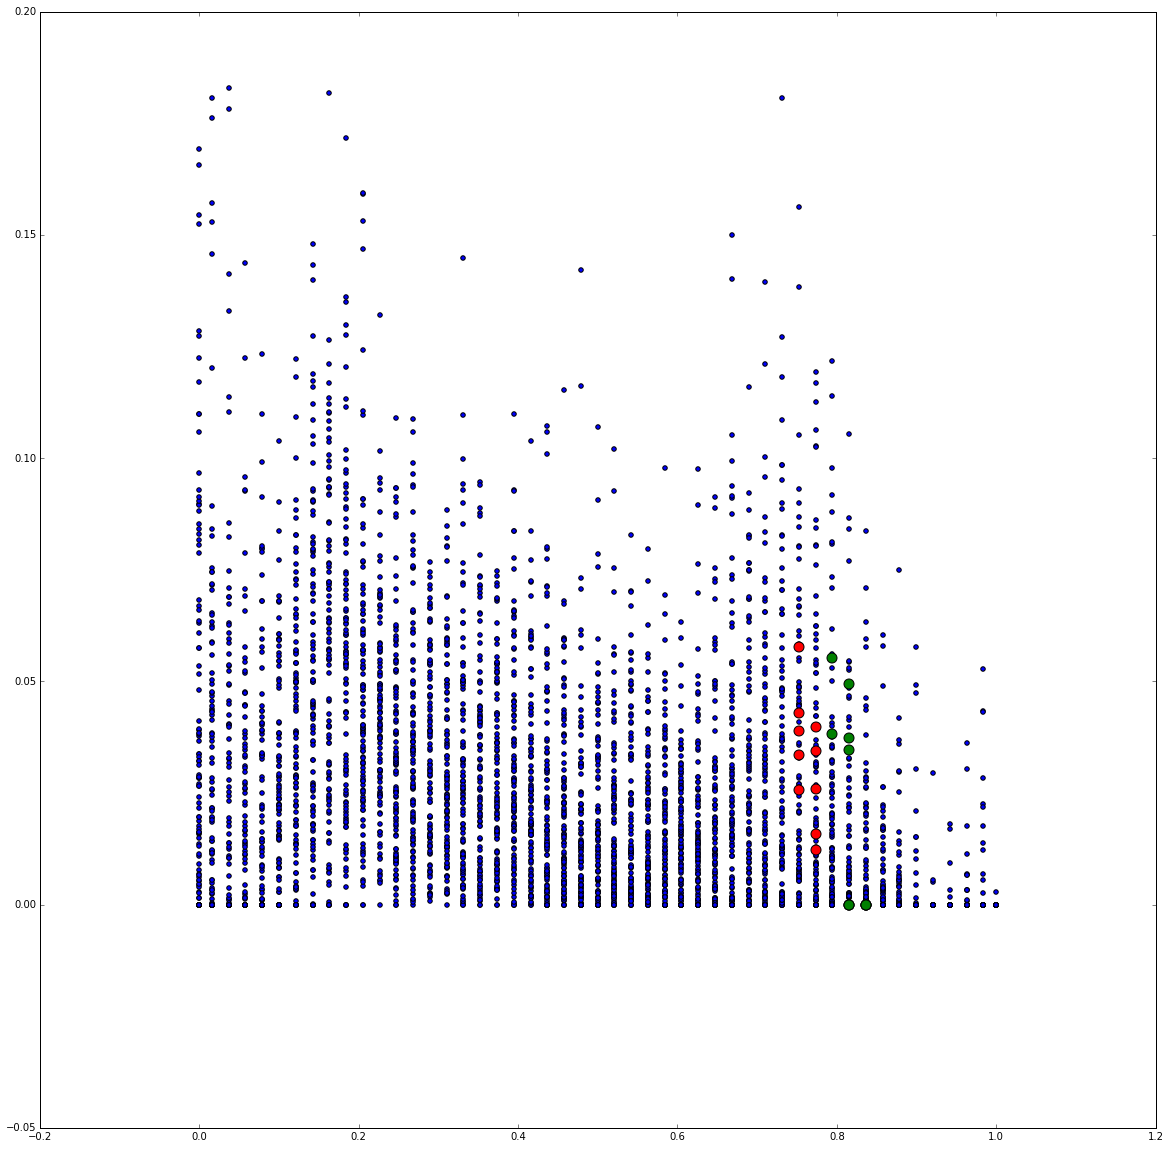

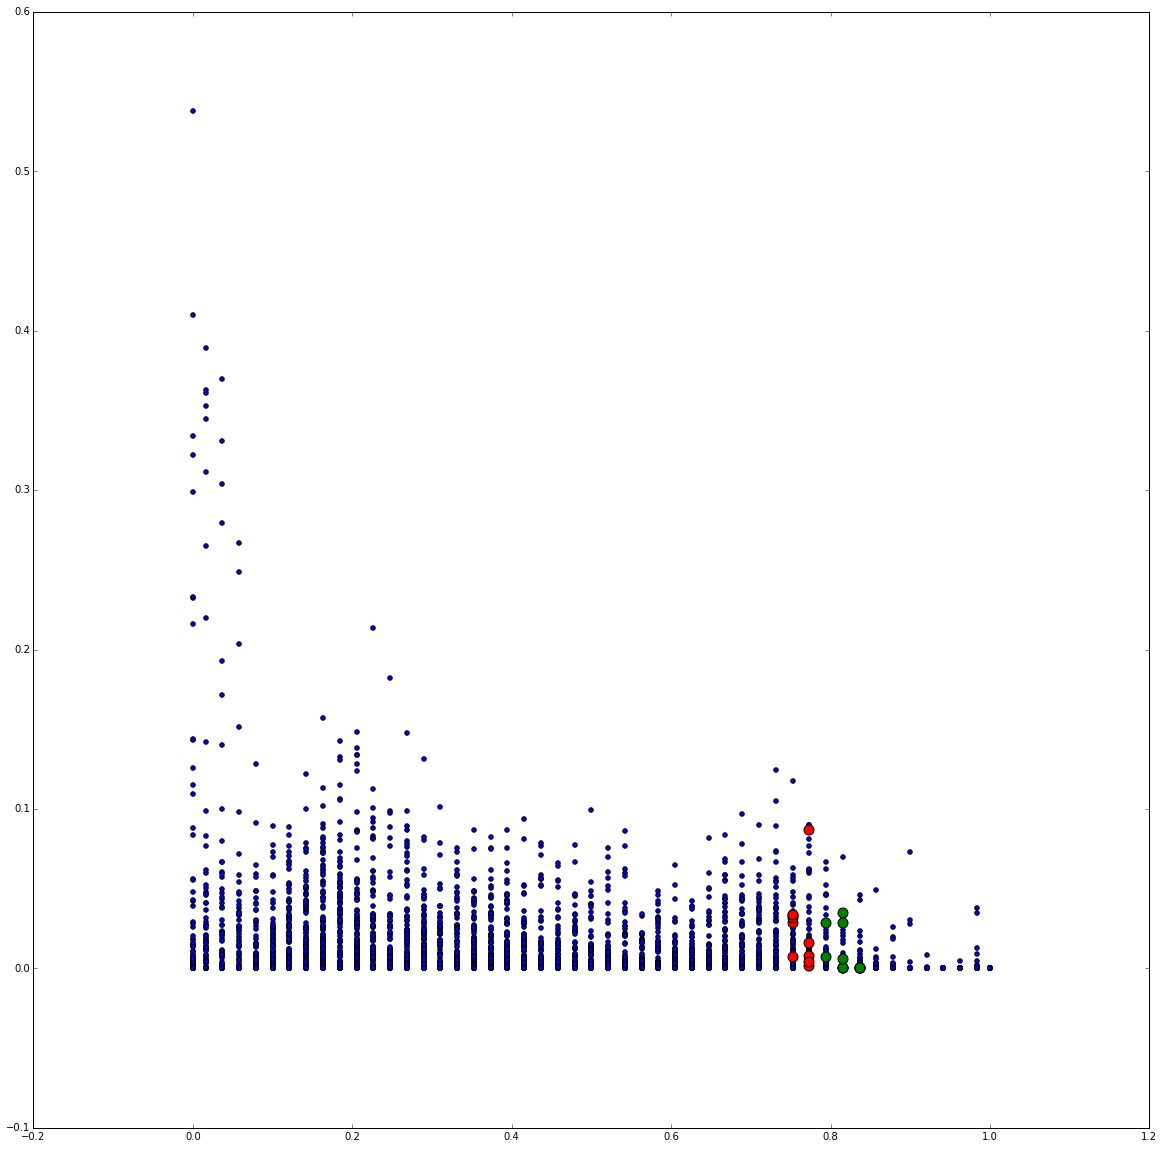

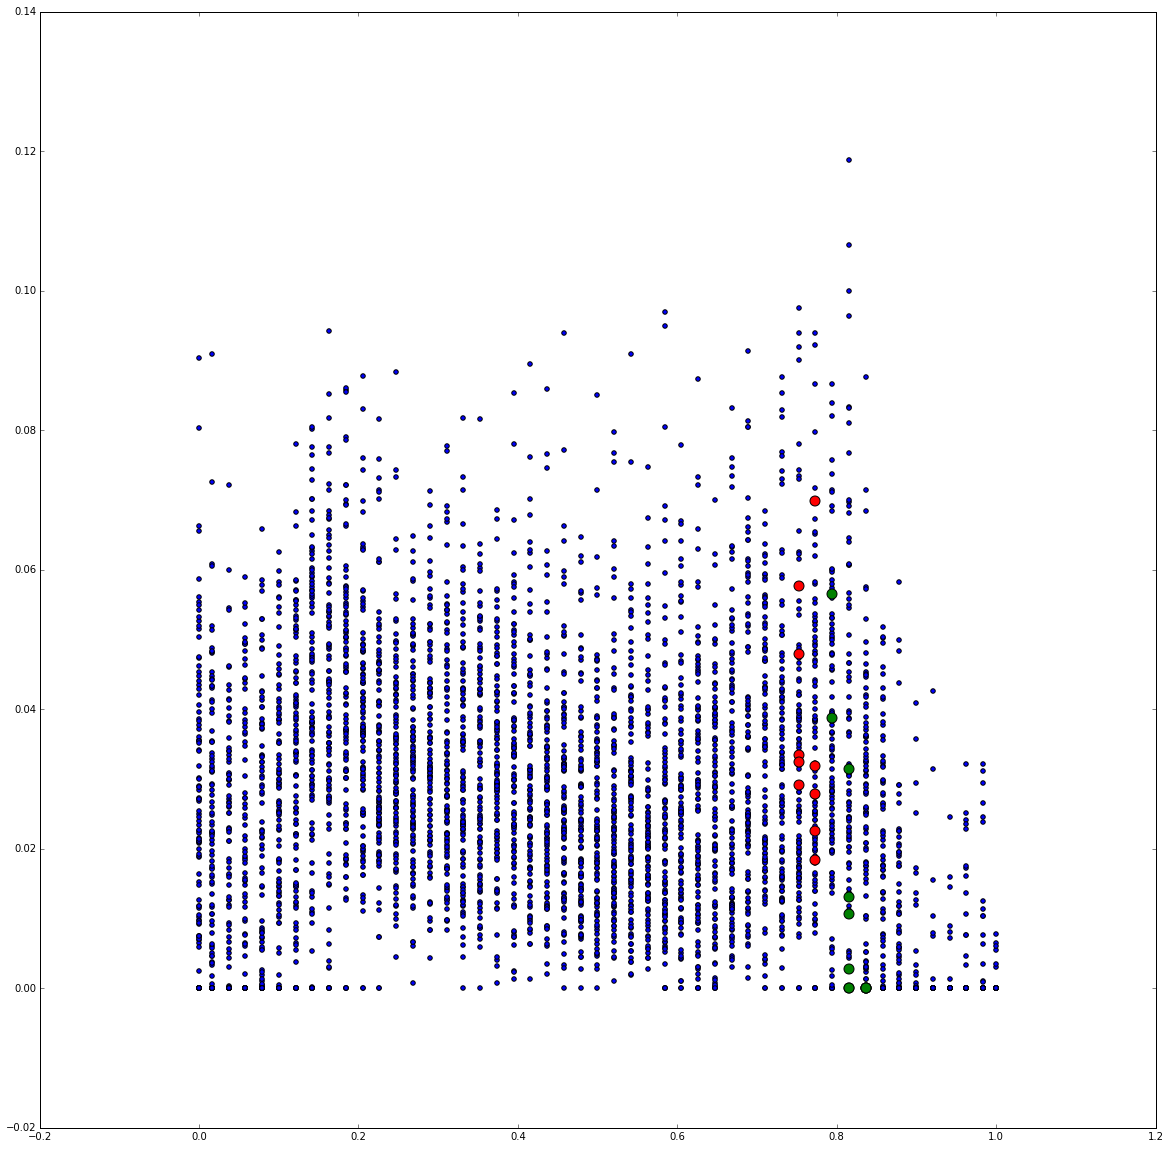

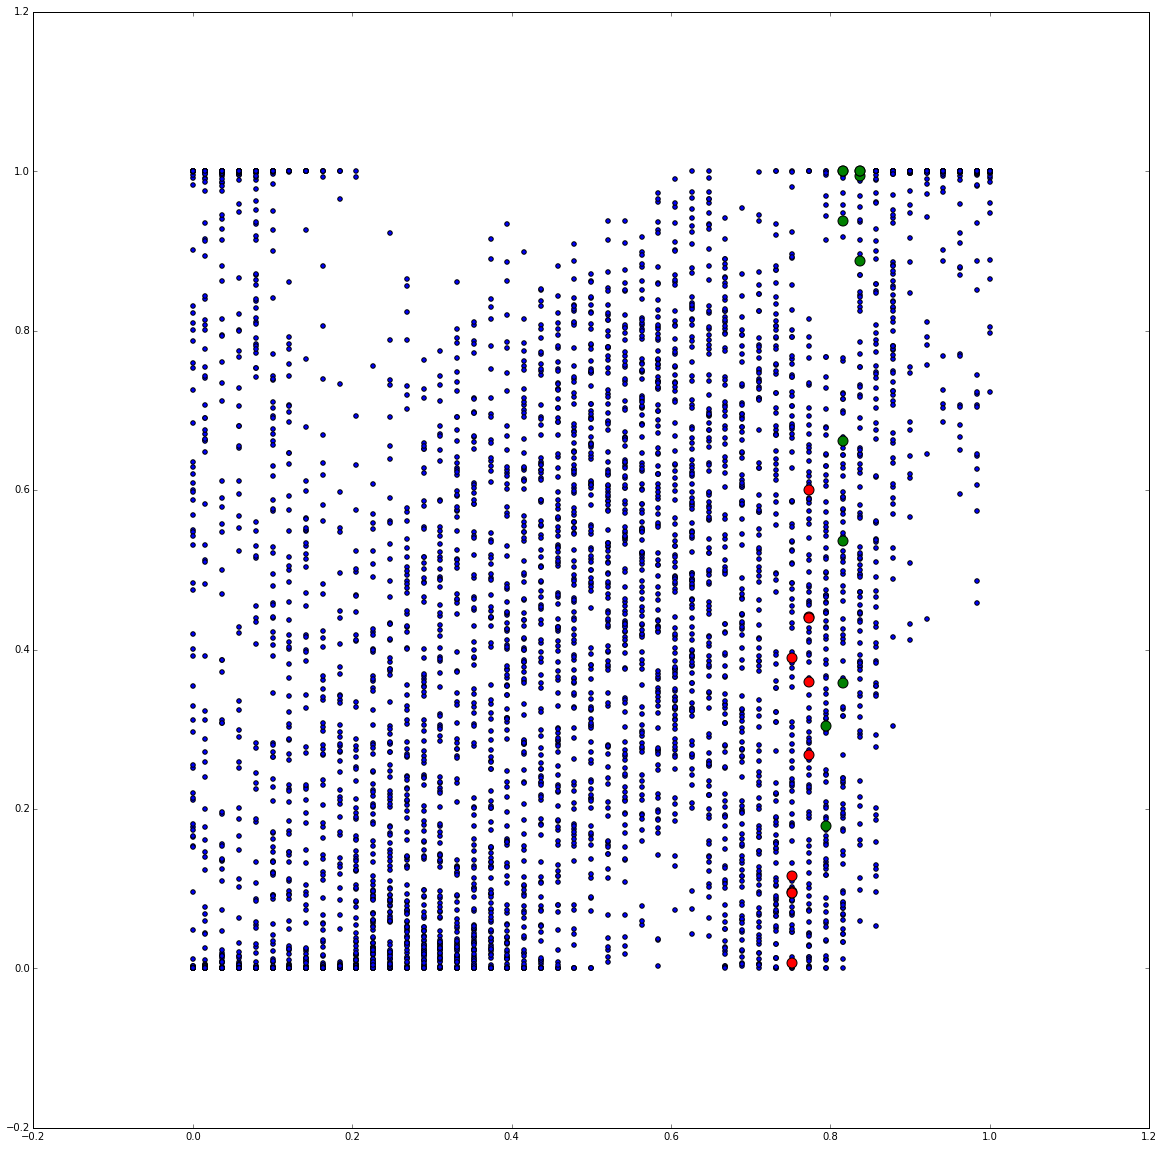

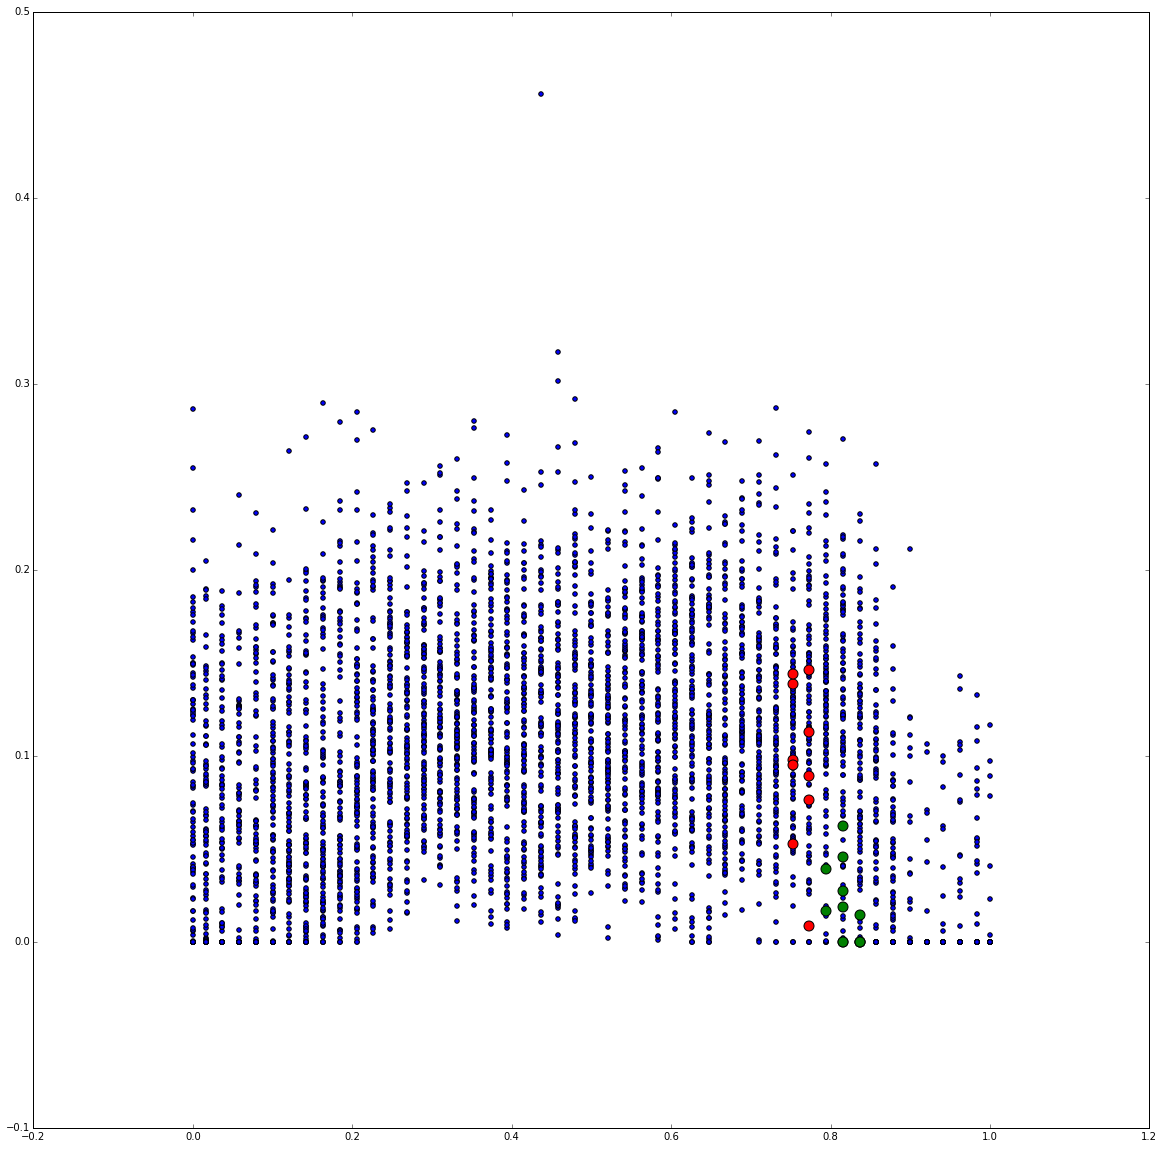

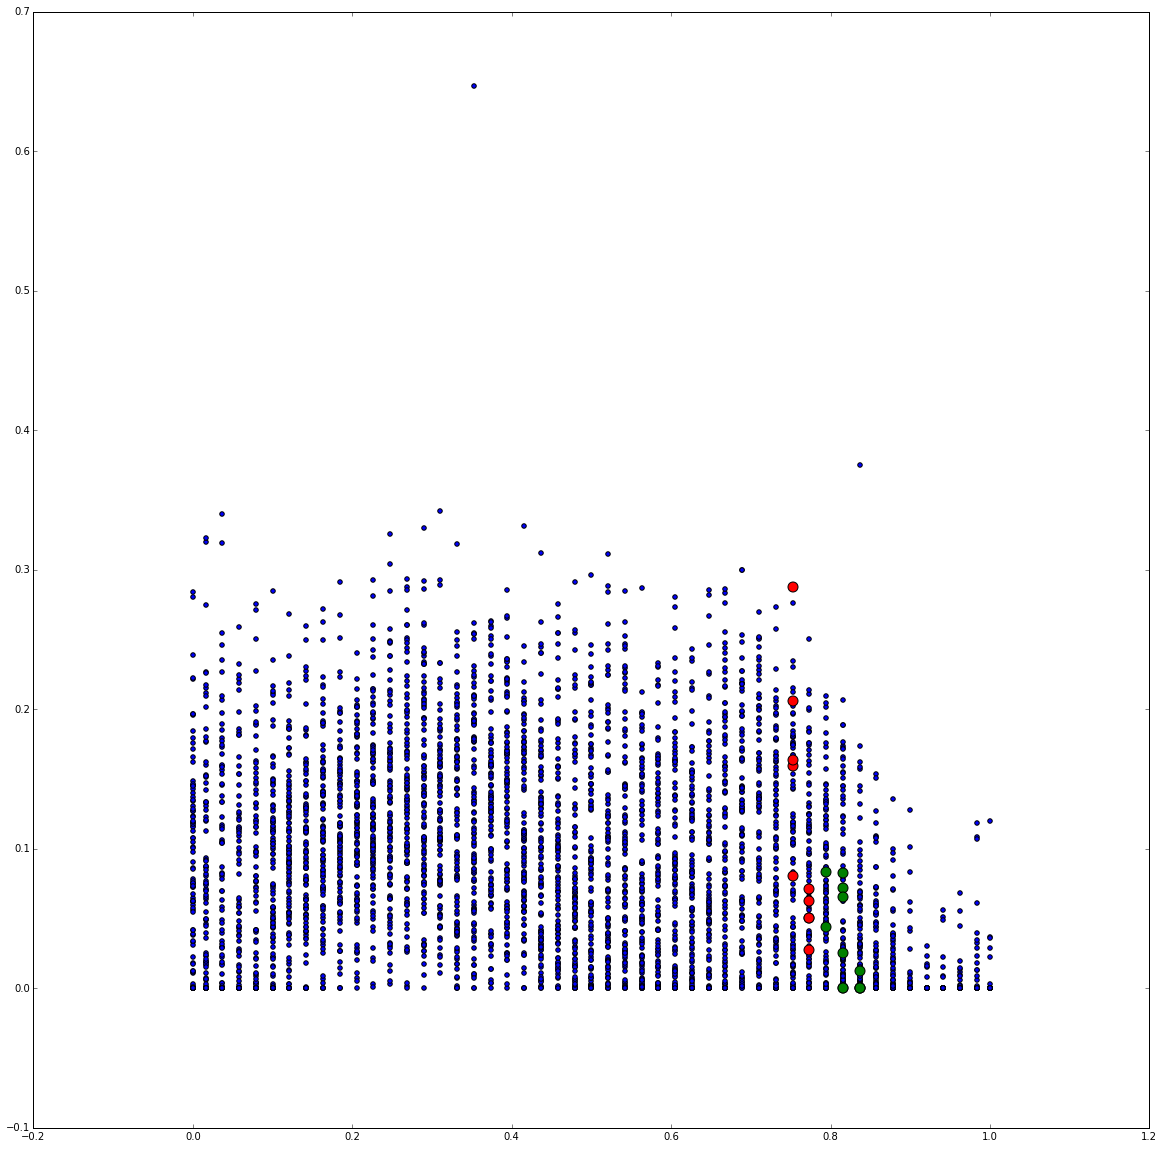

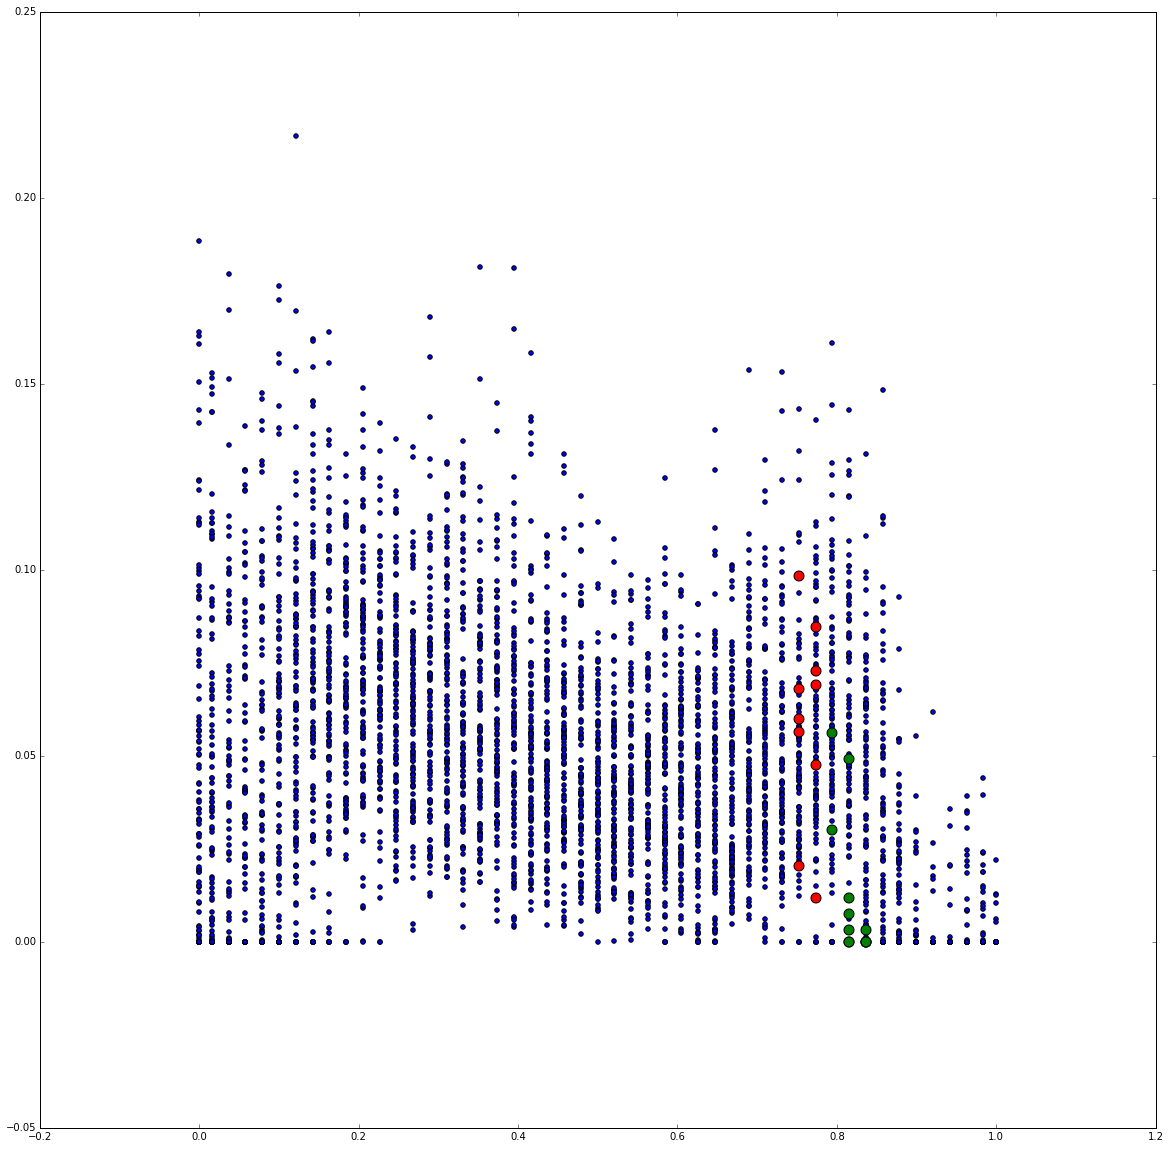

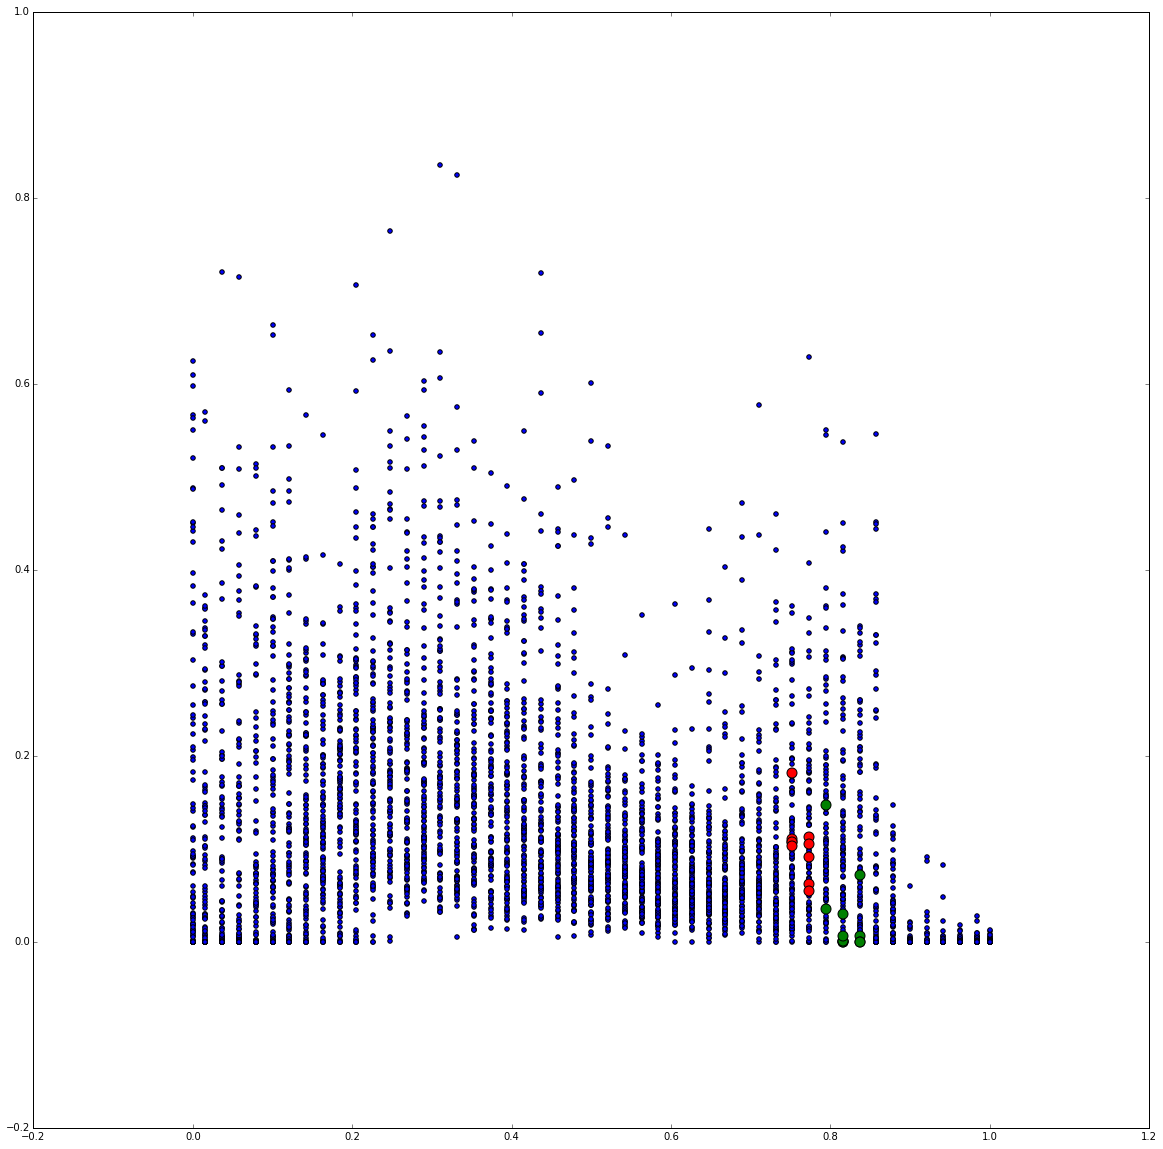

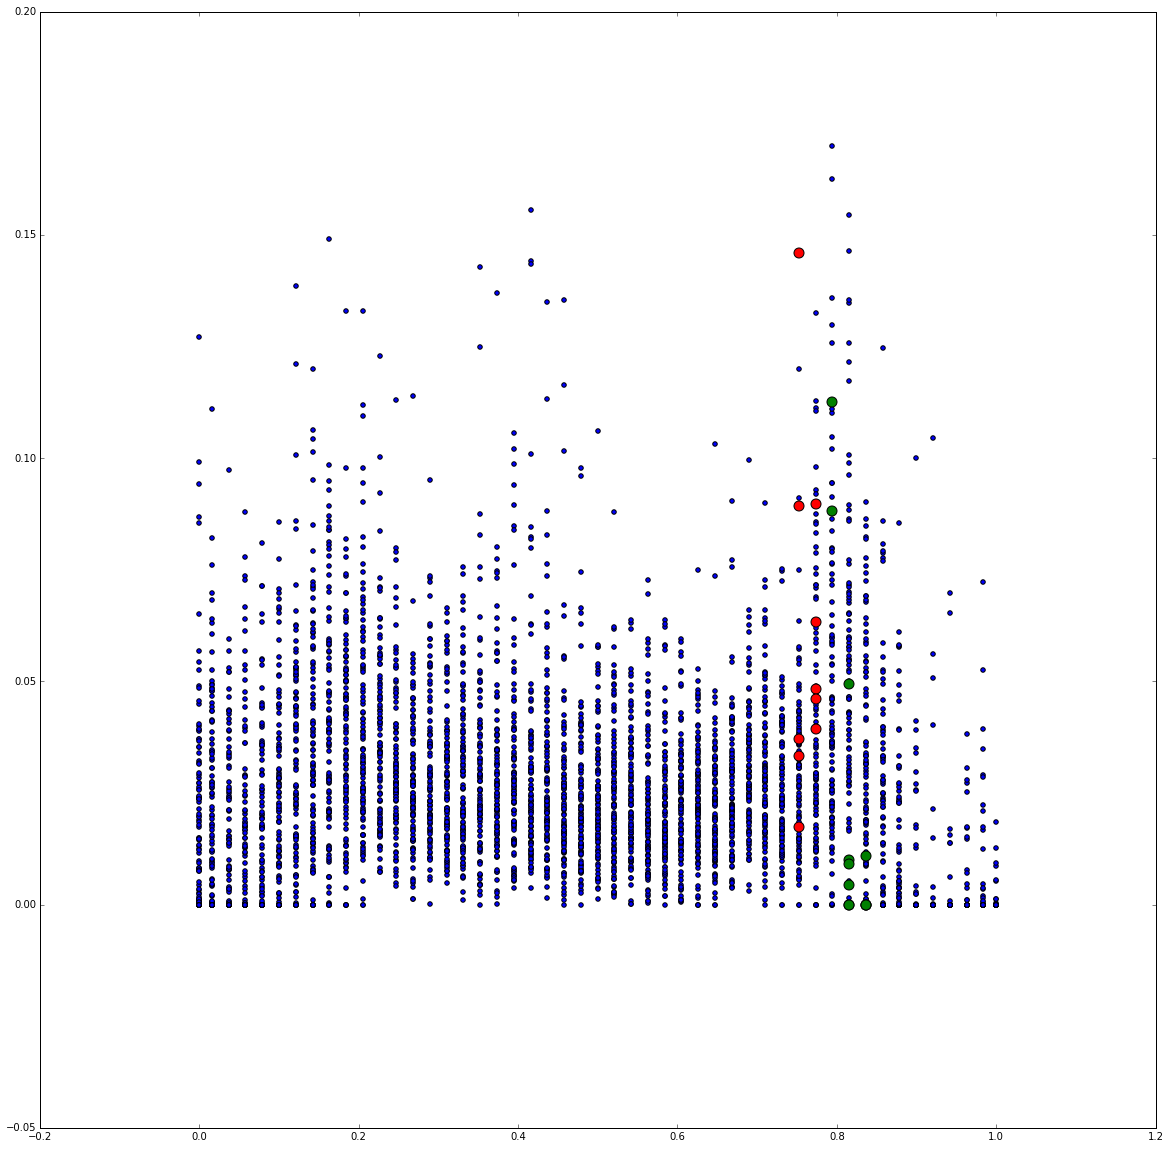

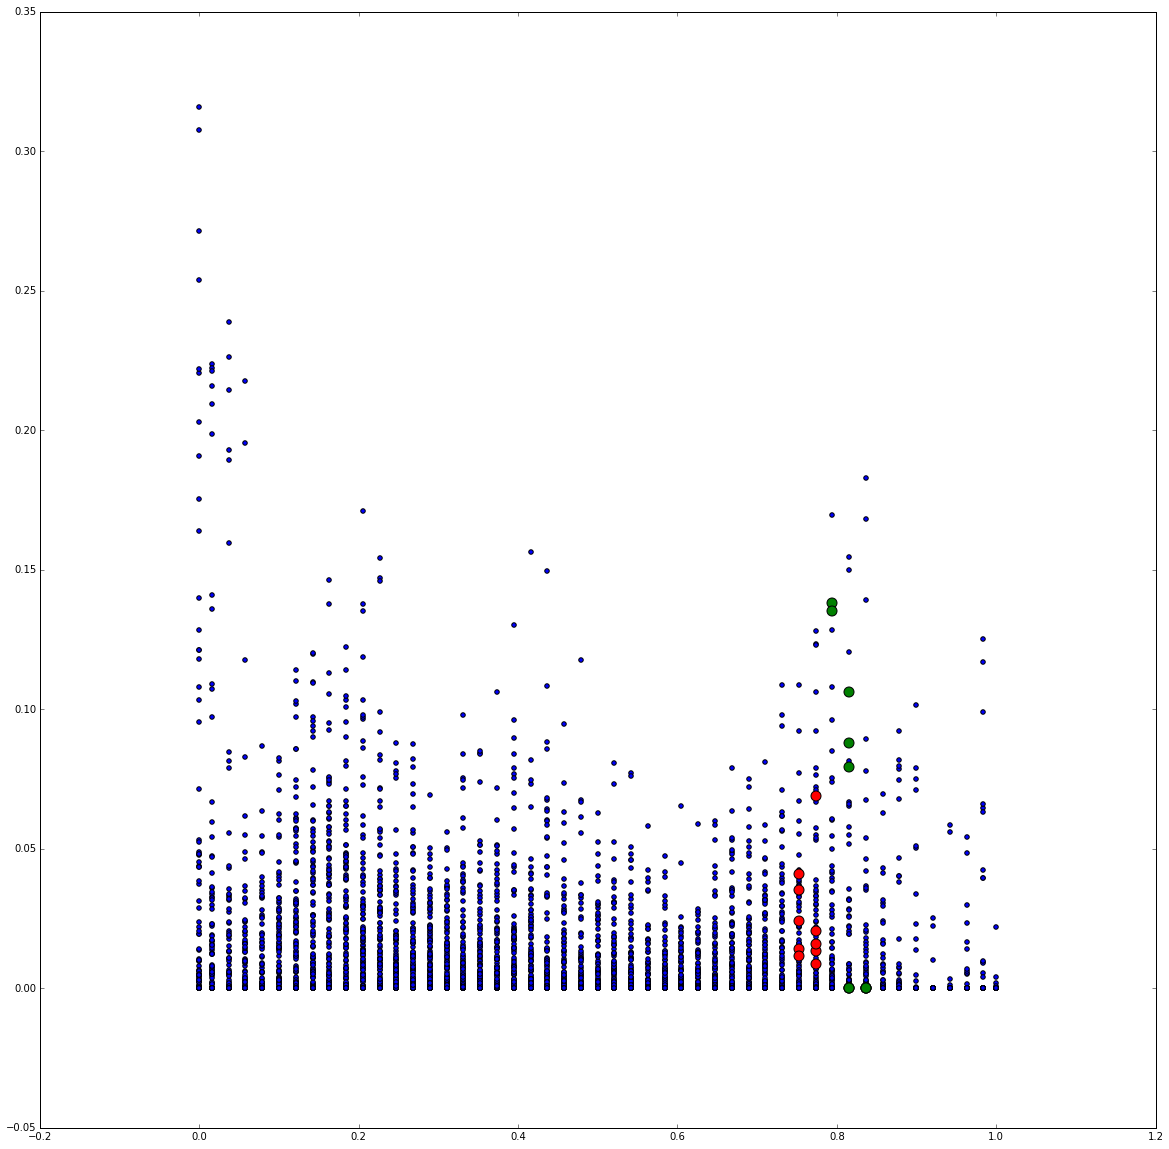

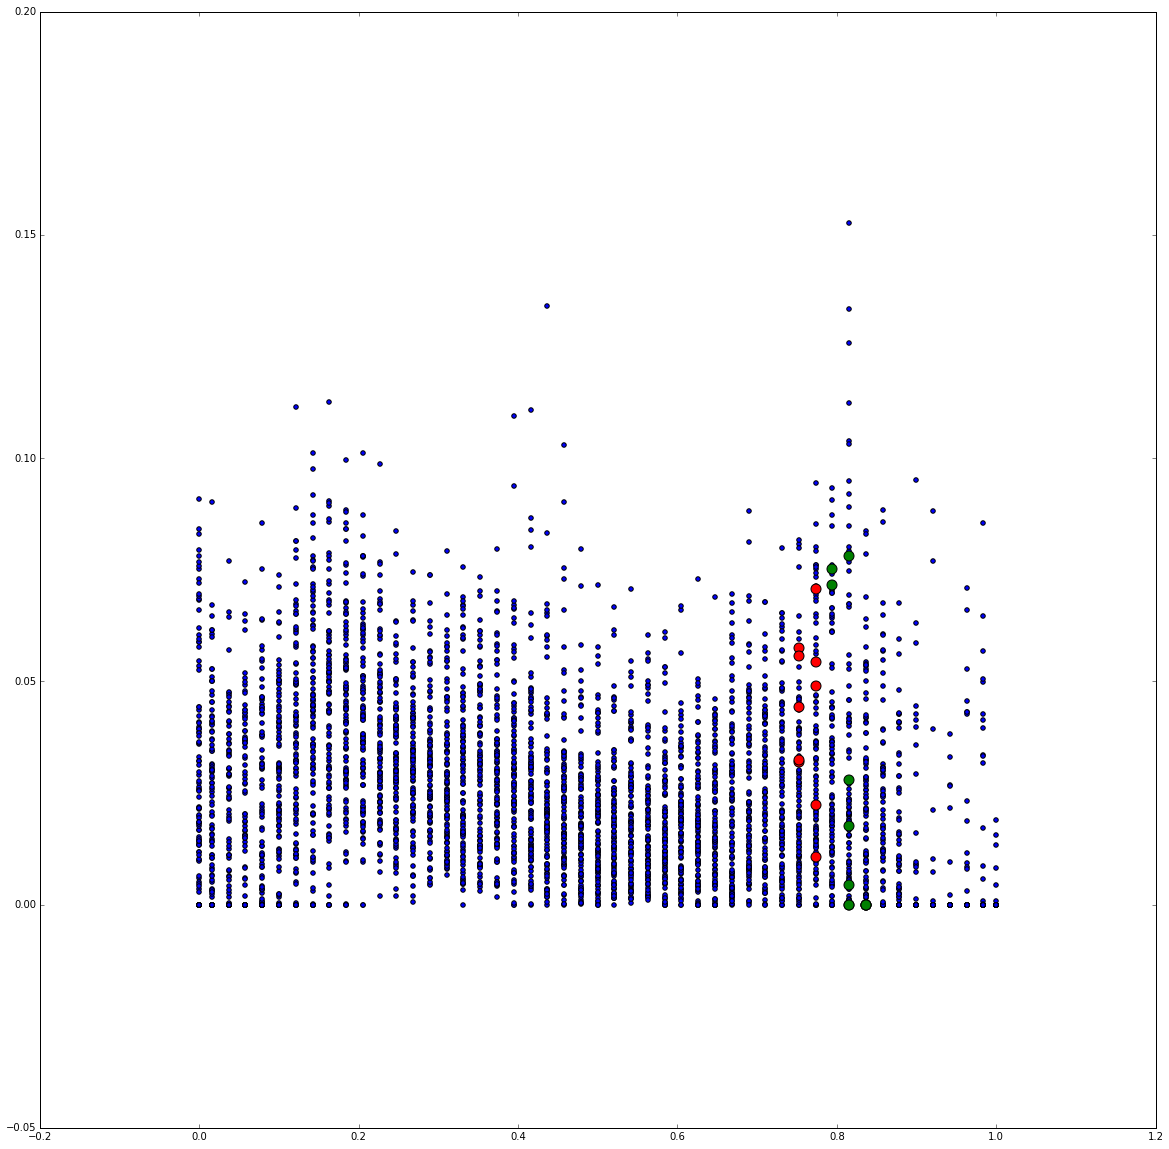

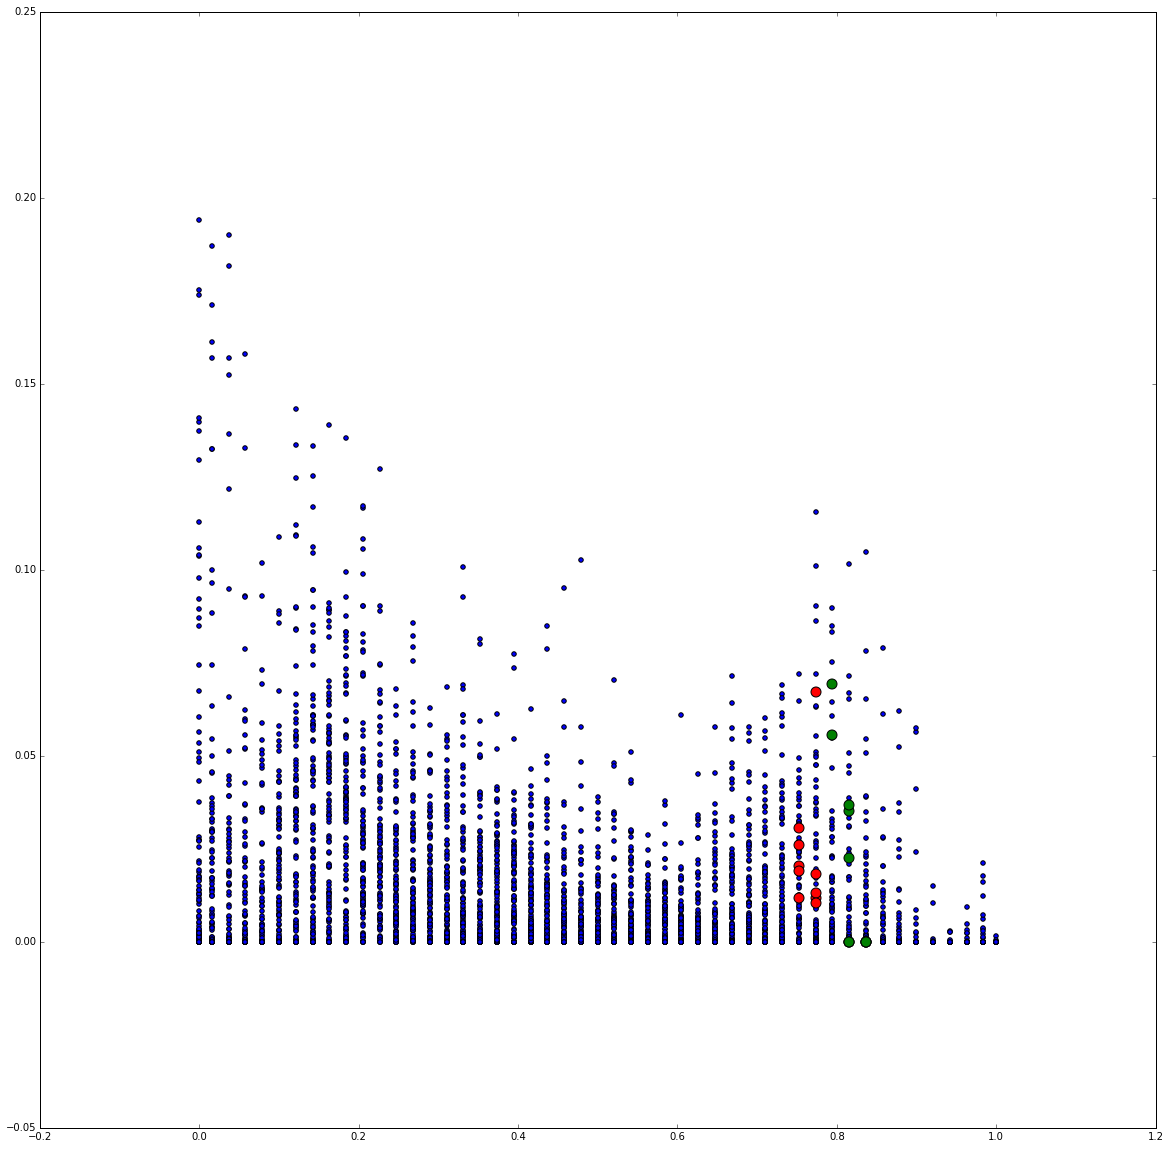

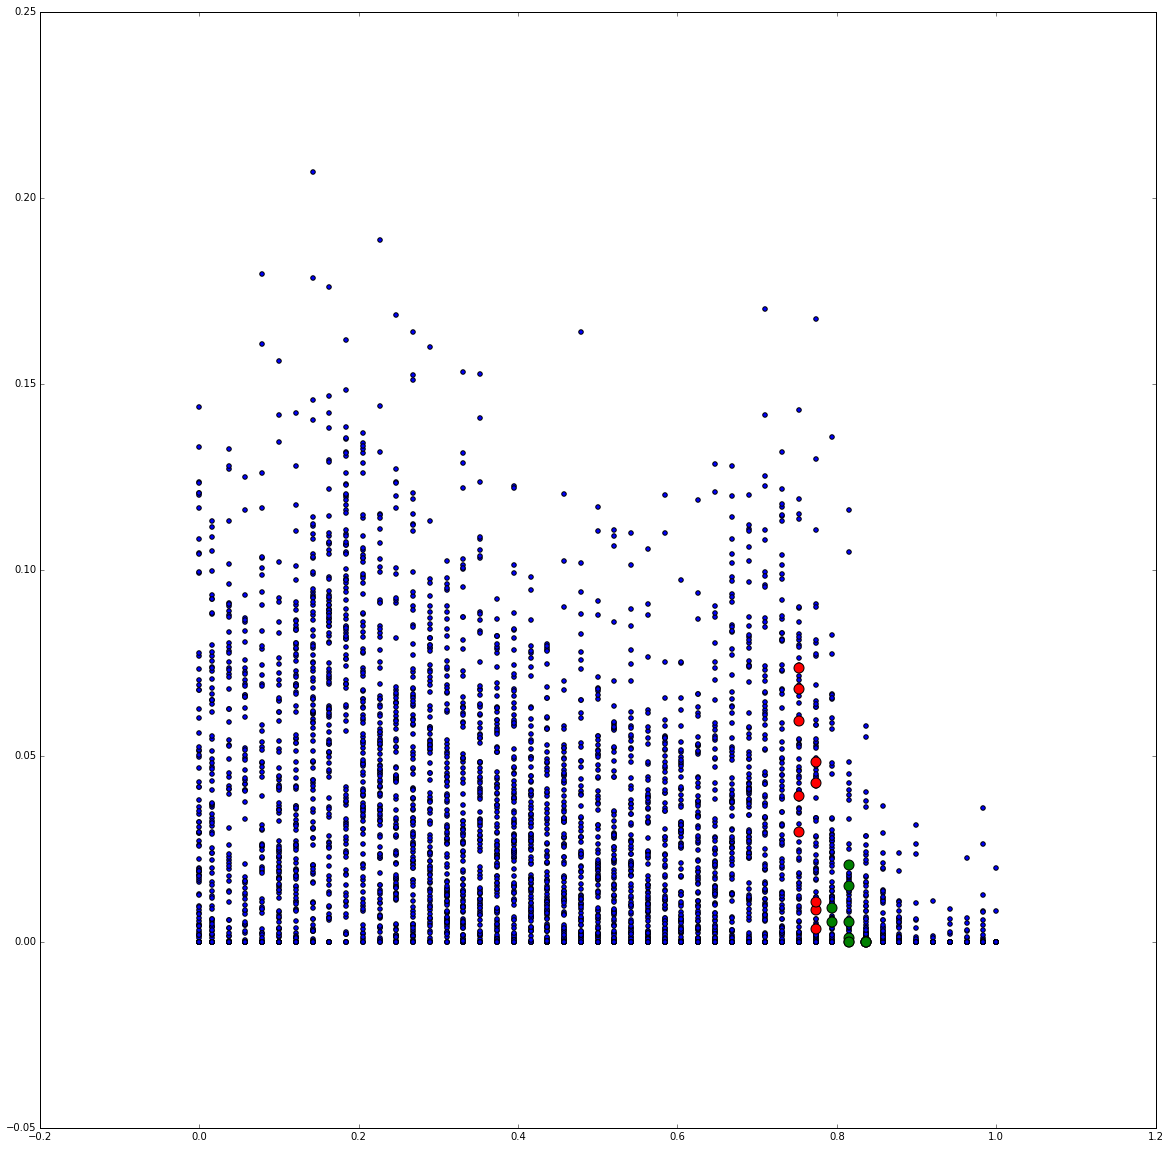

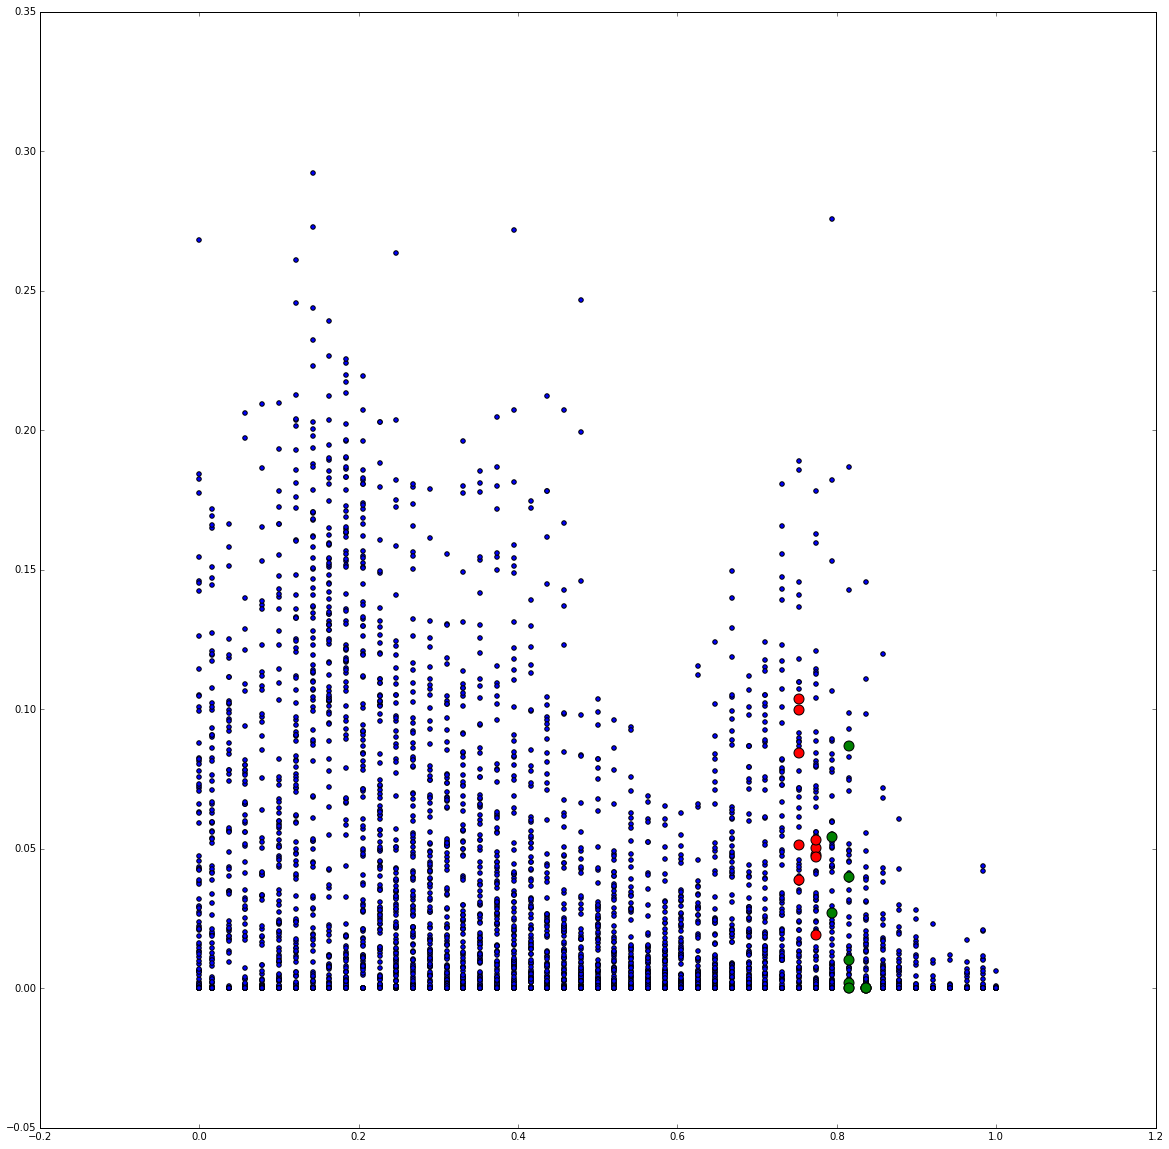

In [50]:
for i in range(n_texton):
    plt.figure(figsize=(20,20));
    plt.scatter(spCentroids_normalized_all_sections[7][:,0], texHist_all_sections[7][:,i]);
    plt.scatter(spCentroids_normalized_all_sections[7][cluster,0], texHist_all_sections[7][cluster,i], c='r', s=100);
    plt.scatter(spCentroids_normalized_all_sections[7][cluster2,0], texHist_all_sections[7][cluster2,i], c='g', s=100);
    plt.show()
    
#     plt.figure(figsize=(20,20));
#     plt.scatter(spCentroids_normalized_all_sections[7][:,1], texHist_all_sections[7][:,i]);
#     plt.scatter(spCentroids_normalized_all_sections[7][cluster,1], texHist_all_sections[7][cluster,i], c='r', s=100);
#     plt.scatter(spCentroids_normalized_all_sections[7][cluster2,0], texHist_all_sections[7][cluster2,i], c='g', s=100);
#     plt.show()

In [313]:
weights = np.ones((spCentroids_all_sections[0].shape[0],))/spCentroids_all_sections[0].shape[0]

In [330]:
feature_distribution = np.empty((n_texton+2,))

for i in range(n_texton):
    feature_distribution[i] = np.sum(texHist_all_sections[0][:,i] * weights) / np.sum(weights)
    
feature_distribution[n_texton] = np.sum(spCentroids_all_sections[0][:,0] * weights) / np.sum(weights)
feature_distribution[n_texton+1] = np.sum(spCentroids_all_sections[0][:,1] * weights) / np.sum(weights)

In [1]:
feature_distribution

NameError: name 'feature_distribution' is not defined

In [335]:
weights2 = np.ones((spCentroids_all_sections[10].shape[0],))/spCentroids_all_sections[10].shape[0]

In [336]:
feature_distribution2 = np.empty((n_texton+2,))

for i in range(n_texton):
    feature_distribution2[i] = np.sum(texHist_all_sections[10][:,i] * weights2) / np.sum(weights2)
    
feature_distribution2[n_texton] = np.sum(spCentroids_all_sections[10][:,0] * weights2) / np.sum(weights2)
feature_distribution2[n_texton+1] = np.sum(spCentroids_all_sections[10][:,1] * weights2) / np.sum(weights2)

In [337]:
feature_distribution2

array([  2.61287895e-02,   1.55868293e-02,   2.97144856e-02,
         3.57999256e-01,   9.32644162e-02,   9.50363873e-02,
         5.18462935e-02,   1.61543103e-01,   3.92137051e-02,
         1.67522912e-02,   2.79007448e-02,   1.53176820e-02,
         2.93760670e-02,   4.03199499e-02,   4.24953061e+03,
         6.04917961e+03])

In [317]:
feature_distribution = np.empty((n_texton+2, 10))
feature_bins = np.empty((n_texton+2, 11))

for i in range(n_texton):
    feature_distribution[i], feature_bins[i] = np.histogram(texHist_all_sections[0][:,i], bins=10, weights=weights)
    
feature_distribution[n_texton], feature_bins[n_texton] = np.histogram(spCentroids_all_sections[0][:,0], bins=10, weights=weights)
feature_distribution[n_texton+1], feature_bins[n_texton+1] = np.histogram(spCentroids_all_sections[0][:,1], bins=10, weights=weights)

In [324]:
feature_distribution2 = np.empty((n_texton+2, 10))

In [325]:
for i in range(n_texton):
    feature_distribution2[i], _ = np.histogram(texHist_all_sections[10][:,i], bins=feature_bins[i], weights=weights)
    
feature_distribution2[n_texton], _ = np.histogram(spCentroids_all_sections[0][:,0], bins=feature_bins[n_texton], weights=weights)
feature_distribution2[n_texton+1], _ = np.histogram(spCentroids_all_sections[0][:,1], bins=feature_bins[n_texton+1], weights=weights)

In [326]:
feature_distribution2[9]

array([  8.05428968e-01,   1.23439667e-01,   4.39865266e-02,
         1.72379631e-02,   5.54785021e-03,   2.97206261e-03,
         3.96275015e-04,   5.94412522e-04,   3.96275015e-04,
         0.00000000e+00])

In [323]:
feature_distribution[11].sum()

0.99999999999994627

In [9]:
# for section_id in slide_indices:

# dm = DataManager(stack=stack_name, section=section_id)

representative_clusters = dm.load_pipeline_result('representativeClusters', 'pkl')

representative_cluster_scores_sorted, representative_clusters_sorted_by_score, \
representative_cluster_indices_sorted_by_score, big_groups_sorted_by_score = zip(*representative_clusters)

neighbors = dm.load_pipeline_result('neighbors', 'pkl')
edge_coords = dm.load_pipeline_result('edgeCoords', 'pkl')
neighbors_long_border = [set([nbr for nbr in nbrs if edge_coords[frozenset([n,nbr])].shape[0] > 20]) 
                 for n, nbrs in enumerate(neighbors)]
dm.save_pipeline_result(neighbors_long_border, 'neighborsLongBorder', 'pkl')

neighbors_global = dm.load_pipeline_result('neighborsLongBorder', 'pkl')

segmentation = dm.load_pipeline_result('segmentation', 'npy')
n_superpixels = len(np.unique(segmentation)) - 1 

#     import time    
#     b = time.time()
edgeSets = Parallel(n_jobs=16)(delayed(spSet_to_edgeSet)(c, n_superpixels=n_superpixels,
                                    fill_holes=True) for c in representative_clusters_sorted_by_score[:30])

#     print time.time() - b
dm.save_pipeline_result(edgeSets, 'closedRegionsTop30Edgesets', 'pkl')

saved /home/yuncong/project/DavidData2014results/RS140/0000/RS140_x5_0000_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_neighborsLongBorder.pkl
saved /home/yuncong/project/DavidData2014results/RS140/0000/RS140_x5_0000_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_closedRegionsTop30Edgesets.pkl
saved /home/yuncong/project/DavidData2014results/RS140/0001/RS140_x5_0001_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_neighborsLongBorder.pkl
saved /home/yuncong/project/DavidData2014results/RS140/0001/RS140_x5_0001_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_closedRegionsTop30Edgesets.pkl
saved /home/yuncong/project/DavidData2014results/RS140/0002/RS140_x5_0002_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_neighborsLongBorder.pkl
saved /home/yuncong/project/DavidData2014results/RS140/0002/RS140_x5_0002_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_closedRegionsTop30Edgesets.pkl
saved /home/yuncong/project/DavidData2014results/RS140/0003/R

IOError: [Errno 2] No such file or directory: '/home/yuncong/project/DavidData2014results/RS140/0037/RS140_x5_0037_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_representativeClusters.pkl'

In [12]:
def gen_visualization(section_id):
    
    dm = DataManager(generate_hierarchy=False, stack=stack_name, resol='x5', section=section_id)
    
    edgeSets = dm.load_pipeline_result('closedRegionsTop30Edgesets', 'pkl')    

    vis = dm.visualize_edge_sets(edgeSets[:10])
    dm.save_pipeline_result( vis, 'contoursTop10' , 'jpg')

    vis = dm.visualize_edge_sets(edgeSets[:20])
    dm.save_pipeline_result( vis, 'contoursTop20' , 'jpg')

    vis = dm.visualize_edge_sets(edgeSets[:30])
    dm.save_pipeline_result( vis, 'contoursTop30' , 'jpg')
    
#     vis = dm.visualize_edge_sets(edgeSets[:30], text=True)
#     dm.save_pipeline_result( vis, 'contoursTop30WithText' , 'jpg')

In [13]:
Parallel(n_jobs=16)(delayed(gen_visualization)(sec) for sec in slide_indices)

saved /home/yuncong/project/DavidData2014results/RS140/0000/RS140_x5_0000_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_contoursTop10.jpg
saved /home/yuncong/project/DavidData2014results/RS140/0002/RS140_x5_0002_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_contoursTop10.jpg
saved /home/yuncong/project/DavidData2014results/RS140/0001/RS140_x5_0001_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_contoursTop10.jpg
saved /home/yuncong/project/DavidData2014results/RS140/0006/RS140_x5_0006_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_contoursTop10.jpg
saved /home/yuncong/project/DavidData2014results/RS140/0003/RS140_x5_0003_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_contoursTop10.jpg
saved /home/yuncong/project/DavidData2014results/RS140/0005/RS140_x5_0005_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_contoursTop10.jpg
saved /home/yuncong/project/DavidData2014results/RS140/0007/RS140_x5_0007_gabor-blueNisslWide-segm-blueNisslRegular-vq

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]